In [17]:
# %% [code]
import sys
import os

# Optionally, add the project root to sys.path if needed.
# project_root = os.path.join(os.path.dirname(__file__), '..')
# if project_root not in sys.path:
#     sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

# Import modules from your project.
from data.synthetic_data import generate_synthetic_data
from methods.lasso_cd import lasso_coordinate_descent
from methods.lasso_fista import lasso_fista
from methods.lasso_ista import lasso_ista
from methods.square_root_lasso import square_root_lasso
from utils.plotting import plot_coefficient_evolution  # Your custom plotting function.

# Define your configuration directly in the notebook.
config = {
    "dataset": {
        "type": "synthetic",
        "n_samples": 100,
        "n_features": 1000,
        "n_informative": 20,
        "noise": 3,
        "random_state": 42
    },
    "algorithms": {
        "lasso_cd": {
            "lam": 0.1,
            "max_iter": 5000,
            "tol": 1e-4,
            "threshold": 1e-2
        },
        "lasso_fista": {
            "lam": 0.1,
            "max_iter": 5000,
            "tol": 1e-4,
            "threshold": 0.1
        },
        "lasso_ista": {
            "lam": 0.1,
            "max_iter": 100000,
            "tol": 1e-4,
            "threshold": 0.1
        },
        "square_root_lasso": {
            "tau": 0.2,
            "max_outer_iter": 250,
            "tol": 1e-4,
            "threshold": 0.0
        }
    }
}

def run_experiment(algo_name, X_scaled, y_centered, config_algo):
    print(f"Running experiment for {algo_name}...")
    if algo_name == "lasso_cd":
        beta_est, beta_history = lasso_coordinate_descent(
            X_scaled, y_centered,
            lam=config_algo["lam"],
            max_iter=config_algo["max_iter"],
            tol=config_algo["tol"]
        )
    elif algo_name == "lasso_fista":
        beta_est, beta_history = lasso_fista(
            X_scaled, y_centered,
            lam=config_algo["lam"],
            max_iter=config_algo["max_iter"],
            tol=config_algo["tol"]
        )
    elif algo_name == "lasso_ista":
        beta_est, beta_history = lasso_ista(
            X_scaled, y_centered,
            lam=config_algo["lam"],
            max_iter=config_algo["max_iter"],
            tol=config_algo["tol"]
        )
    elif algo_name == "square_root_lasso":
        beta_est, sigma_est, beta_history = square_root_lasso(
            X_scaled, y_centered,
            tau=config_algo["tau"],
            max_outer_iter=config_algo["max_outer_iter"],
            tol=config_algo["tol"]
        )
        # For square-root LASSO, extract only the beta vectors from the history.
        beta_history_arr = np.array([b for sigma, b in beta_history])
        return beta_est, beta_history_arr
    else:
        raise ValueError("Unknown algorithm")
    
    beta_history_arr = np.array(beta_history)
    return beta_est, beta_history_arr

def evaluate_and_plot(beta_est, beta_history_arr, true_informative_indices, X_scaled, config_algo, algo_name):
    """
    Evaluates the experiment by comparing the selected features against ground truth.
    Returns a dictionary with various metrics and the beta history array.
    """
    # Determine selected features based on the threshold.
    threshold = config_algo.get("threshold", 1e-2)
    selected_indices = np.where(beta_est > threshold)[0]
    n_features = X_scaled.shape[1]
    n_selected = len(selected_indices)
    n_not_selected = n_features - n_selected

    print(f"\n{algo_name} results:")
    print("Number of features selected (nonzero coefficients):", n_selected)
    print("Indices of selected features:", selected_indices)
    
    # Compute correctly and wrongly selected features.
    common_features = set(selected_indices).intersection(set(true_informative_indices))
    correct_count = len(common_features)
    wrong_count = n_selected - correct_count
    fraction = correct_count / len(true_informative_indices) if len(true_informative_indices) > 0 else 0

    print("Recovered informative features (intersection):", sorted(common_features))
    print("Fraction of ground truth features recovered: {}/{} = {:.2f}".format(
        correct_count, len(true_informative_indices), fraction))
    
    # Optionally, you can also call your plotting function here.
    # plot_coefficient_evolution(beta_history_arr, selected_indices, n_features)
    
    # Return all the details we want to store.
    return {
        "n_selected": n_selected,
        "selected_indices": selected_indices.tolist(),
        "correct_count": correct_count,
        "wrong_count": wrong_count,
        "fraction_recovered": fraction,
        "beta_history_shape": beta_history_arr.shape,
        "beta_history": beta_history_arr  # Stored as a numpy array (object).
    }

# %% [code]
# Generate the synthetic dataset.
data_config = config["dataset"]
X_data, y_data, true_coef = generate_synthetic_data(
    n_samples=data_config["n_samples"],
    n_features=data_config["n_features"],
    n_informative=data_config["n_informative"],
    noise=data_config["noise"],
    random_state=data_config["random_state"]
)
true_informative_indices = np.where(true_coef != 0)[0]

# Standardize the data.
X_mean = np.mean(X_data, axis=0)
X_std = np.std(X_data, axis=0)
X_scaled = (X_data - X_mean) / X_std
y_centered = y_data - np.mean(y_data)

# %% [code]
# Create a list to store experiment results.
results = []

# Run each algorithm defined in the configuration.
for algo_name, algo_config in config["algorithms"].items():
    start_time = time.time()
    beta_est, beta_history_arr = run_experiment(algo_name, X_scaled, y_centered, algo_config)
    elapsed_time = time.time() - start_time
    
    metrics = evaluate_and_plot(beta_est, beta_history_arr, true_informative_indices, X_scaled, algo_config, algo_name)
    
    # Store the results in a dictionary.
    results.append({
        "Algorithm": algo_name,
        "Time (s)": elapsed_time,
        "n_selected": metrics["n_selected"],
        "Selected Indices": metrics["selected_indices"],
        "Correct Count": metrics["correct_count"],
        "Wrong Count": metrics["wrong_count"],
        "Fraction Recovered": metrics["fraction_recovered"],
        "Beta History Shape": metrics["beta_history_shape"],
        "Parameters": algo_config,  # Hyperparameters used.
        "Beta History": metrics["beta_history"]
    })

# Convert the results list to a Pandas DataFrame and display it.
results_df = pd.DataFrame(results)
print("\nExperiment Results:")
display(results_df)


Running experiment for lasso_cd...
Converged at iteration 3849

lasso_cd results:
Number of features selected (nonzero coefficients): 62
Indices of selected features: [ 37  39  40  80 150 180 205 235 245 269 277 287 291 299 316 341 371 372
 397 413 424 425 435 438 446 449 451 469 487 535 542 544 571 574 578 588
 614 692 700 710 718 724 727 731 778 782 790 793 800 839 843 849 856 882
 883 925 929 933 934 943 983 997]
Recovered informative features (intersection): [np.int64(150), np.int64(180), np.int64(205), np.int64(287), np.int64(299), np.int64(424), np.int64(438), np.int64(574), np.int64(700), np.int64(710), np.int64(731), np.int64(778), np.int64(782), np.int64(793), np.int64(800), np.int64(856), np.int64(882), np.int64(983)]
Fraction of ground truth features recovered: 18/20 = 0.90
Running experiment for lasso_fista...

lasso_fista results:
Number of features selected (nonzero coefficients): 56
Indices of selected features: [ 37  39  40 150 180 205 235 245 269 277 287 291 299 316 34

,Algorithm,Time (s),n_selected,Selected Indices,Correct Count,Wrong Count,Fraction Recovered,Beta History Shape,Parameters,Beta History
0,lasso_cd,38.100741,62,"[37, 39, 40, 80, 150, 180, 205, 235, 245, 269,...",18,44,0.9,"(3850, 1000)","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ...","[[-10.786440071035138, -3.7470078542433436, -2..."
1,lasso_fista,0.186928,56,"[37, 39, 40, 150, 180, 205, 235, 245, 269, 277...",18,38,0.9,"(5000, 1000)","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ...","[[-0.6367723171470776, -0.23881054210507985, -..."
2,lasso_ista,2.441623,55,"[40, 80, 150, 180, 205, 235, 245, 269, 277, 28...",18,37,0.9,"(70650, 1000)","{'lam': 0.1, 'max_iter': 100000, 'tol': 0.0001...","[[-0.6367723171470776, -0.23881054210507985, -..."
3,square_root_lasso,5.940453,41,"[45, 150, 180, 205, 245, 267, 269, 287, 291, 2...",18,23,0.9,"(67, 1000)","{'tau': 0.2, 'max_outer_iter': 250, 'tol': 0.0...","[[-0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0..."


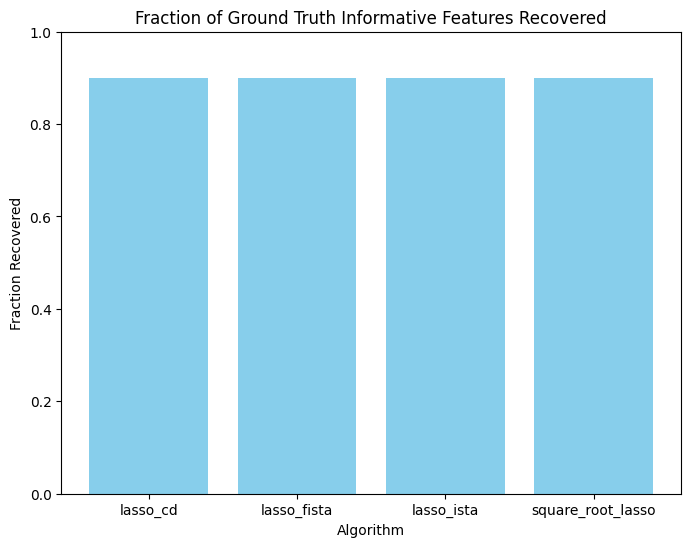

In [18]:
import matplotlib.pyplot as plt

# Plot fraction recovered for each algorithm.
plt.figure(figsize=(8, 6))
plt.bar(results_df["Algorithm"], results_df["Fraction Recovered"], color='skyblue')
plt.xlabel("Algorithm")
plt.ylabel("Fraction Recovered")
plt.title("Fraction of Ground Truth Informative Features Recovered")
plt.ylim(0, 1)
plt.show()


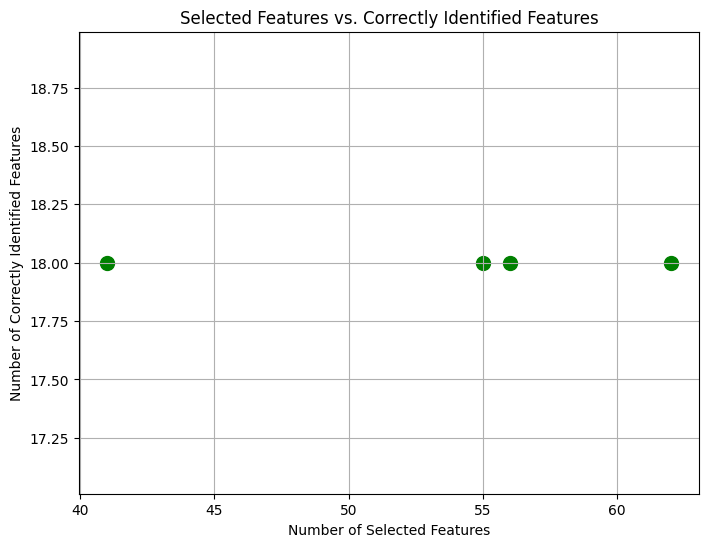

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(results_df["n_selected"], results_df["Correct Count"], s=100, c='green')
plt.xlabel("Number of Selected Features")
plt.ylabel("Number of Correctly Identified Features")
plt.title("Selected Features vs. Correctly Identified Features")
plt.grid(True)
plt.show()


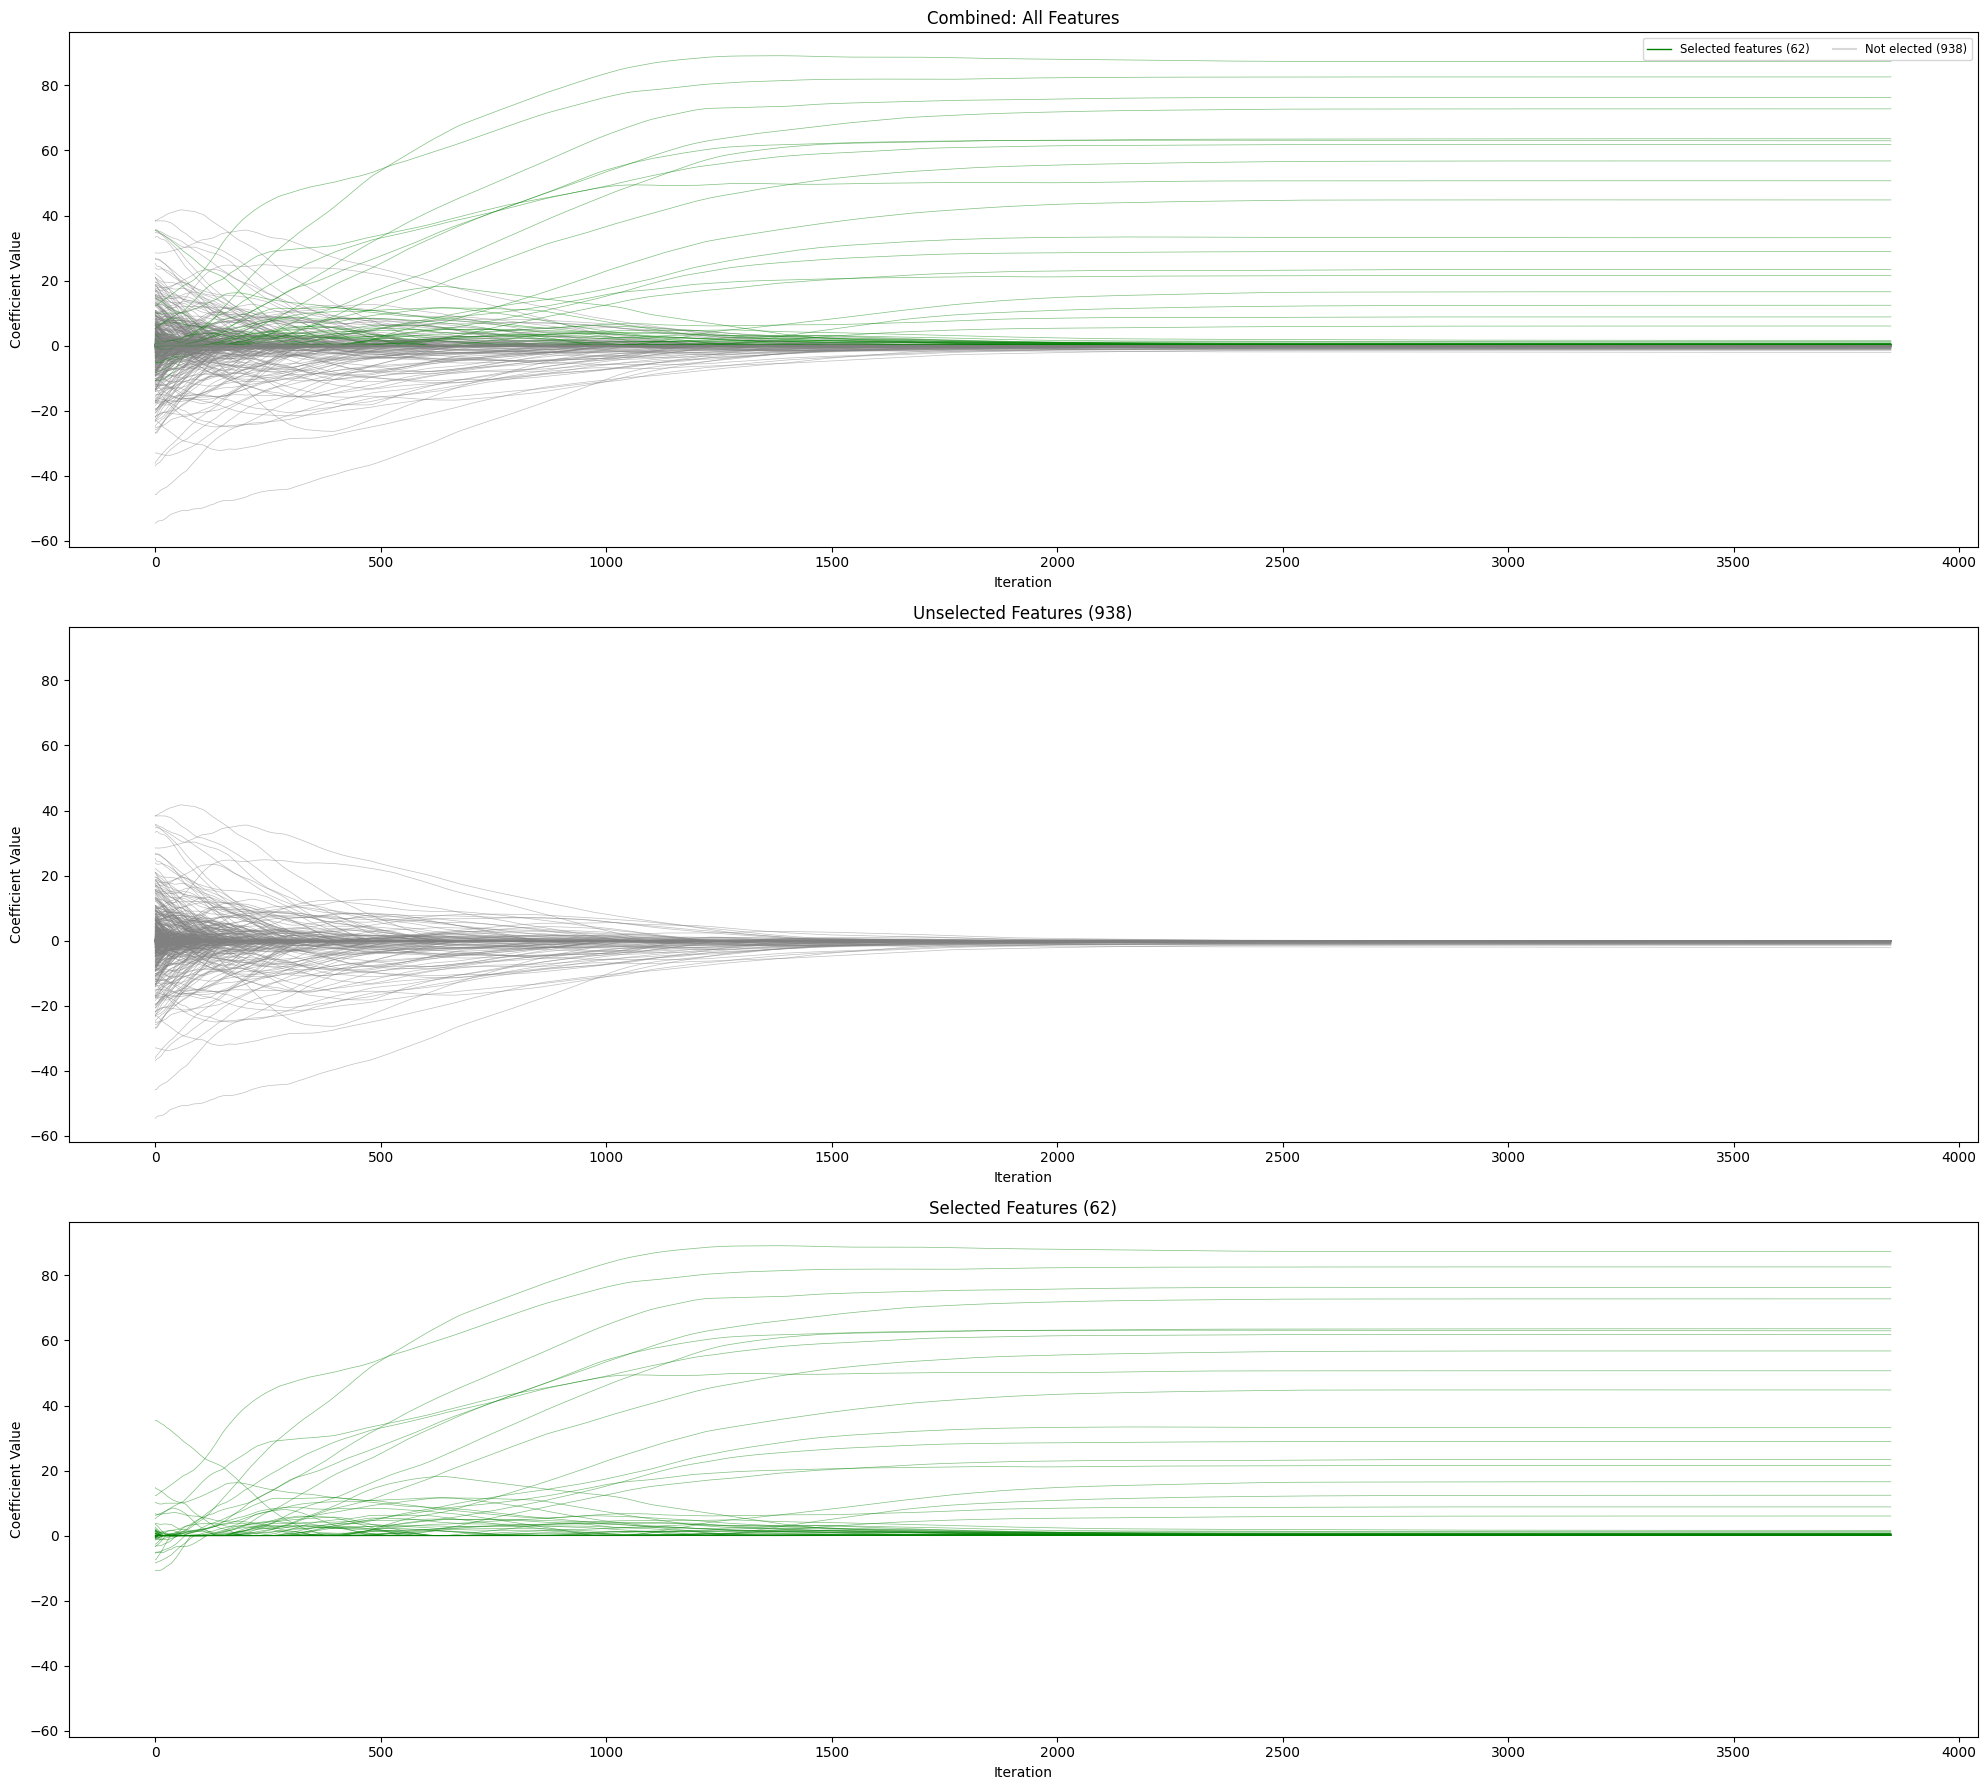

In [20]:
# Retrieve the beta history for the 'lasso_cd' experiment.
beta_history_lasso_cd = results_df.loc[results_df["Algorithm"] == "lasso_cd", "Beta History"].iloc[0]
# Also, you need the selected indices for that experiment. Assume you stored them as well:
selected_indices_lasso_cd = results_df.loc[results_df["Algorithm"] == "lasso_cd", "Selected Indices"].iloc[0]
# And assume the total number of features is stored or known (here, 1000).
total_features = config["dataset"]["n_features"]

# Now call your custom plotting function.
plot_coefficient_evolution(beta_history_lasso_cd, selected_indices_lasso_cd, total_features)
